In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import os

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

# CONFIGURATION
NUM_AGENTS = 5
BATCH_SIZE = 64
EPOCHS = 1
ROUNDS = 50
LR = 0.01
LAMBDA_STAR = 0.87
TRAIN_SAMPLES_PER_AGENT = 8000
VAL_SAMPLES_PER_AGENT = 2000
TEST_SAMPLES_PER_AGENT = 2000
FIG_DIR = "./figures_exp_iid"
os.makedirs(FIG_DIR, exist_ok=True)

# Small Convolutional Neural Network for MNIST
class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.net(x)

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Partition IID data with fixed sizes
def partition_iid_fixed(dataset, num_agents, train_per_agent, val_per_agent):
    total_needed = num_agents * (train_per_agent + val_per_agent)
    indices = np.random.permutation(len(dataset))[:total_needed]
    
    train_loaders, val_loaders = [], []

    for i in range(num_agents):
        start = i * (train_per_agent + val_per_agent)
        end = start + train_per_agent + val_per_agent
        agent_indices = indices[start:end]
        train_indices = agent_indices[:train_per_agent]
        val_indices = agent_indices[train_per_agent:]

        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    return train_loaders, val_loaders

# Global test set (new samples not used in training/validation)
def build_global_test_loader(dataset, samples_per_agent):
    indices = np.random.permutation(len(dataset))[:samples_per_agent * NUM_AGENTS]
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=128, shuffle=False)

train_loaders, val_loaders = partition_iid_fixed(
    train_dataset, NUM_AGENTS, TRAIN_SAMPLES_PER_AGENT, VAL_SAMPLES_PER_AGENT
)
test_loader = build_global_test_loader(test_dataset, TEST_SAMPLES_PER_AGENT)

# Training function
def train(model, loader, lambda_star=LAMBDA_STAR):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=lambda_star * 1e-2)
    loss_fn = nn.CrossEntropyLoss()
    running_loss = 0
    total_batches = 0
    for _ in range(EPOCHS):
        for x, y in loader:
            optimizer.zero_grad()
            pred = model(x)
            ce_loss = loss_fn(pred, y)
            loss = (1 - lambda_star) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_batches += 1
    return running_loss / total_batches

# Evaluation function
def evaluate(model, loader, return_preds=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            pred_labels = pred.argmax(1)
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    if return_preds:
        return accuracy, np.array(all_preds), np.array(all_labels)
    return accuracy

# Federated averaging
def federated_avg(models):
    global_model = SmallConvNet()
    global_dict = global_model.state_dict()
    for key in global_dict:
        global_dict[key] = torch.stack([m.state_dict()[key].float() for m in models], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

In [34]:
# Initialize models and logs

LAMBDA_STAR = 0.87

models = [SmallConvNet() for _ in range(NUM_AGENTS)]
agent_accuracies = [[] for _ in range(NUM_AGENTS)]
agent_losses = [[] for _ in range(NUM_AGENTS)]
agent_f1_scores = [[] for _ in range(NUM_AGENTS)]

# Federated training loop
for rnd in range(ROUNDS):
    print(f"\n--- Round {rnd + 1} ---")
    
    for i in range(NUM_AGENTS):
        loss = train(models[i], train_loaders[i], lambda_star=LAMBDA_STAR)
        agent_losses[i].append(loss)

    global_model = federated_avg(models)
    for i in range(NUM_AGENTS):
        models[i].load_state_dict(global_model.state_dict())

    print("  [Evaluating local models]")
    for i in range(NUM_AGENTS):
        acc, preds, labels = evaluate(models[i], val_loaders[i], return_preds=True)
        f1 = f1_score(labels, preds, average='macro')
        agent_accuracies[i].append(acc)
        agent_f1_scores[i].append(f1)
        print(f"  Agent {i+1}: Accuracy={acc:.4f}, F1 Score={f1:.4f}")

# Final global evaluation
print("\n--- Final Evaluation on Global Test Set ---")
test_acc, test_preds, test_labels = evaluate(global_model, test_loader, return_preds=True)
test_f1 = f1_score(test_labels, test_preds, average='macro')
print(f"\nGlobal Model Accuracy on Test Set: {test_acc:.4f}")
print(f"Global Model F1 Score on Test Set: {test_f1:.4f}")


--- Round 1 ---
  [Evaluating local models]
  Agent 1: Accuracy=0.3180, F1 Score=0.2911
  Agent 2: Accuracy=0.2965, F1 Score=0.2795
  Agent 3: Accuracy=0.3085, F1 Score=0.2888
  Agent 4: Accuracy=0.3115, F1 Score=0.2916
  Agent 5: Accuracy=0.3215, F1 Score=0.2910

--- Round 2 ---
  [Evaluating local models]
  Agent 1: Accuracy=0.8925, F1 Score=0.8903
  Agent 2: Accuracy=0.8990, F1 Score=0.8994
  Agent 3: Accuracy=0.9020, F1 Score=0.9018
  Agent 4: Accuracy=0.8995, F1 Score=0.8985
  Agent 5: Accuracy=0.8965, F1 Score=0.8947

--- Round 3 ---
  [Evaluating local models]
  Agent 1: Accuracy=0.9215, F1 Score=0.9198
  Agent 2: Accuracy=0.9145, F1 Score=0.9137
  Agent 3: Accuracy=0.9190, F1 Score=0.9181
  Agent 4: Accuracy=0.9185, F1 Score=0.9171
  Agent 5: Accuracy=0.9190, F1 Score=0.9170

--- Round 4 ---
  [Evaluating local models]
  Agent 1: Accuracy=0.9400, F1 Score=0.9389
  Agent 2: Accuracy=0.9270, F1 Score=0.9264
  Agent 3: Accuracy=0.9305, F1 Score=0.9300
  Agent 4: Accuracy=0.9315, 

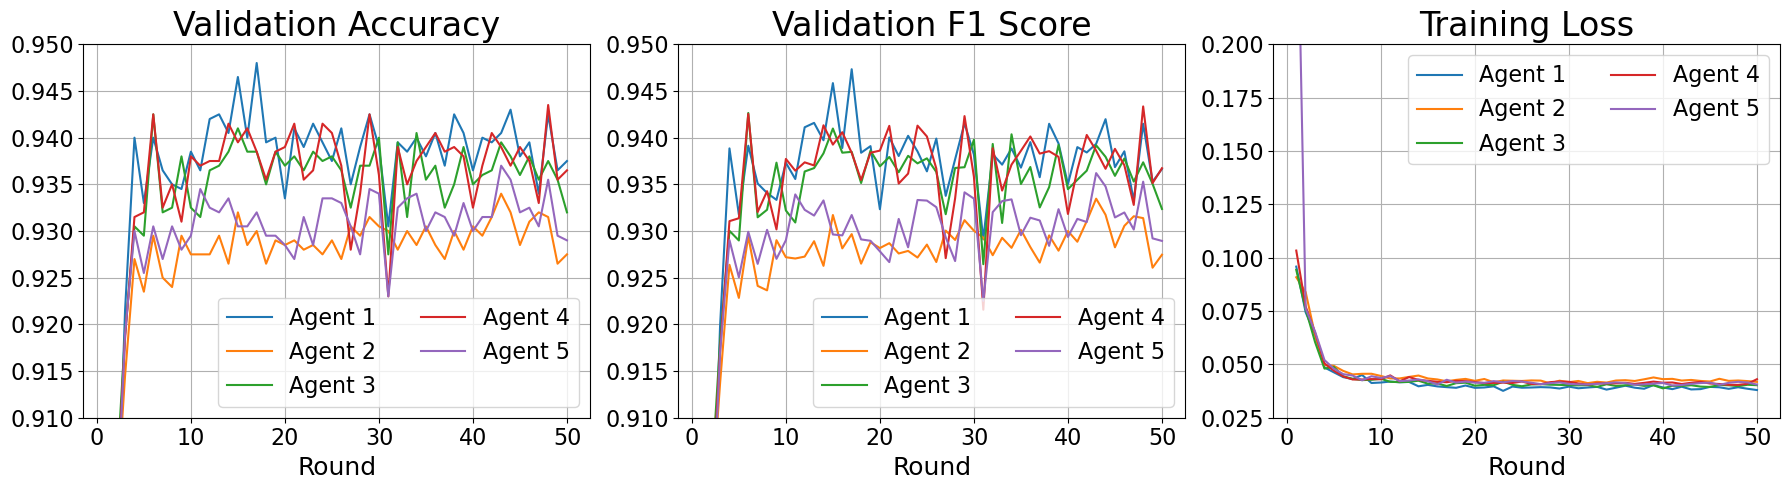

In [37]:
# Plotting results
rounds = list(range(1, ROUNDS + 1))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i in range(NUM_AGENTS):
    axs[0].plot(rounds, agent_accuracies[i], label=f'Agent {i+1}')
    axs[1].plot(rounds, agent_f1_scores[i], label=f'Agent {i+1}')
    axs[2].plot(rounds, agent_losses[i], label=f'Agent {i+1}')

axs[0].set_title('Validation Accuracy', fontsize=24)
axs[0].set_ylim([0.91,0.95])
axs[0].tick_params(axis='both', labelsize=16)

axs[1].set_title('Validation F1 Score', fontsize=24)
axs[1].set_ylim([0.91,0.95])
axs[1].tick_params(axis='both', labelsize=16)

axs[2].set_title('Training Loss', fontsize=24)
axs[2].set_ylim([0.025,0.20])
axs[2].tick_params(axis='both', labelsize=16)

for ax in axs:
    ax.set_xlabel('Round', fontsize=18)
    ax.grid(True)
    ax.legend(fontsize=16, ncol=2)

filename = f"training_metrics_lambda{int(LAMBDA_STAR * 1000):03d}.pdf"
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, filename), dpi=300)
plt.show()